In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Geospatial data processing
import geopandas as gpd
from shapely.geometry import LineString, Point
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from shapely.geometry import LineString
from shapely.geometry import Point
from scipy.spatial import cKDTree

# System operations
import os

In [2]:
# Configure Matplotlib global style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'figure.dpi': 100,
    'font.size': 10
})

In [3]:
root = r'PATH_TO_YOUR_DATA'

In [4]:
od1903 = pd.read_csv(os.path.join(root, 'data', 'od201903.csv'))
od2403 = pd.read_csv(os.path.join(root, 'data', 'od202403.csv'))

# User Attributes

In [5]:
pcount1903 = pd.read_csv(os.path.join(root, 'data', 'pcount19-24','pcount_1903.csv'))
pcount1903 = pcount1903.groupby(['home_grid', 'age', 'gender', 'is_local'], as_index=False).sum()
pcount1903_grid = pcount1903.loc[pcount1903['age'].isin(['a1', 'a2', 'a3', 'a4', 'a5', 'a6','a7']), ['home_grid','pcount']].groupby('home_grid', as_index=False).sum()
pcount1903_grid_s = pcount1903_grid.loc[(pcount1903_grid['pcount']>=10)].sort_index()

pcount2403 = pd.read_csv(os.path.join(root, 'data', 'pcount19-24','pcount_2403.csv'))
pcount2403 = pcount2403.groupby(['home_grid', 'age', 'gender', 'is_local'], as_index=False).sum()
pcount2403_grid = pcount2403.loc[pcount2403['age'].isin(['a1', 'a2', 'a3', 'a4', 'a5', 'a6','a7']),['home_grid','pcount']].groupby('home_grid', as_index=False).sum()
pcount2403_grid_s = pcount2403_grid.loc[(pcount2403_grid['pcount']>=10)].sort_index()

home_grid = set(pcount1903_grid_s['home_grid'].unique()) & set(pcount2403_grid_s['home_grid'].unique())
len(home_grid)

6763

In [6]:
house_price_pop = gpd.read_file(os.path.join(root, 'data', 'shp', 'house_price_fnid_pcount.shp'))
house_price_pop = house_price_pop.loc[house_price_pop['fnid'].isin(home_grid)]
house_price_pop = house_price_pop.drop('pcount', axis=1).merge(pcount1903_grid, left_on='fnid', right_on='home_grid')
price_counts = house_price_pop['price'].repeat(house_price_pop['pcount']).to_list()

cuts = 100 
thresholds = np.percentile(price_counts, np.linspace(0, 100, cuts+1))[1:]
house_price_pop['ses'] = pd.cut(house_price_pop['price'], 
                                bins=[-float('inf')] + list(thresholds) + [float('inf')], 
                                labels=False, include_lowest=True) + 1
cuts = 4 
thresholds = np.percentile(price_counts, np.linspace(0, 100, cuts+1))[1:]
house_price_pop['ses2'] = pd.cut(house_price_pop['price'], 
                                bins=[-float('inf')] + list(thresholds) + [float('inf')], 
                                labels=False, include_lowest=True) + 1
cuts = 10 
thresholds = np.percentile(price_counts, np.linspace(0, 100, cuts+1))[1:]
house_price_pop['ses3'] = pd.cut(house_price_pop['price'], 
                                bins=[-float('inf')] + list(thresholds) + [float('inf')], 
                                labels=False, include_lowest=True) + 1

house_price_id = house_price_pop['fnid'].unique()
house_price_pop = house_price_pop.drop('fnid', axis=1)
house_price_pop

,price,geometry,home_grid,pcount,ses,ses2,ses3
0,29992.0,"POLYGON ((116.28743 39.69516, 116.28743 39.697...",80264,292,3,1,1
1,31235.0,"POLYGON ((116.2845 39.69741, 116.2845 39.69966...",80977,312,3,1,1
2,29992.0,"POLYGON ((116.28743 39.69741, 116.28743 39.699...",80978,170,3,1,1
3,31774.0,"POLYGON ((116.29036 39.69741, 116.29036 39.699...",80979,195,3,1,1
4,30574.0,"POLYGON ((116.28743 39.69966, 116.28743 39.701...",81692,51,3,1,1
...,...,...,...,...,...,...,...
6758,34422.0,"POLYGON ((116.30207 40.16841, 116.30207 40.170...",230209,252,5,1,1
6759,34422.0,"POLYGON ((116.305 40.16841, 116.305 40.17066, ...",230210,47,5,1,1
6760,34992.0,"POLYGON ((116.30793 40.16841, 116.30793 40.170...",230211,19,6,1,1
6761,34422.0,"POLYGON ((116.30207 40.17066, 116.30207 40.172...",230923,56,5,1,1


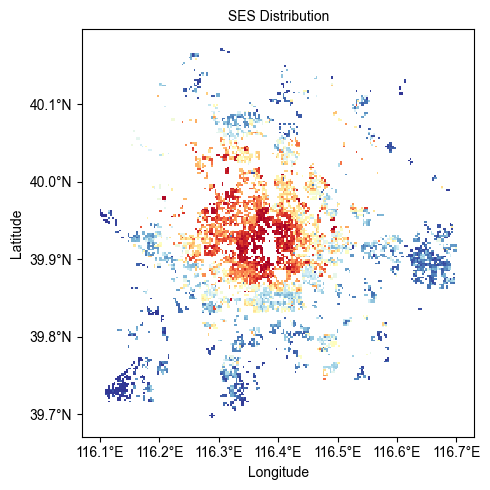

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))

gpd.GeoDataFrame(
    house_price_pop.loc[:, ['ses', 'geometry']],
    geometry=house_price_pop['geometry'],
    crs=4326
).plot('ses', cmap='RdYlBu_r', ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}°E"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}°N"))
ax.set_title('SES Distribution', fontsize=10)
plt.tight_layout()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

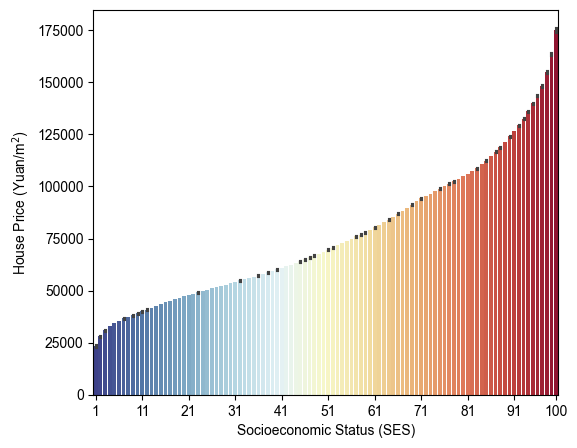

In [8]:
plt.figure(figsize=(6, 5))
sns.barplot(x='ses', y='price', data=house_price_pop, hue='ses', palette='RdYlBu_r', legend=False, estimator='mean')
tick_positions = list(range(0, 101, 10))+[99]
tick_labels = [str(i+1) for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.xlim(-0.5, 99.5)
plt.xlabel('Socioeconomic Status (SES)')
plt.ylabel(r'House Price (Yuan/m$^2$)')
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

In [9]:
def social_attr_stat(df):
    def age_group(age):
        if age in ['a1', 'a2', 'a3']:
            return 'young'
        elif age in ['a6','a7']:
            return 'old'
        return 'other'

    df['age_group'] = df['age'].apply(age_group)

    grouped = df.groupby('home_grid')

    def calculate_age_ratio(x):
        total_pcount = x['pcount'].sum()
        young_pcount = x[x['age_group'] == 'young']['pcount'].sum()
        old_pcount = x[x['age_group'] == 'old']['pcount'].sum()
        young_ratio = young_pcount / total_pcount if total_pcount != 0 else 0
        old_ratio = old_pcount / total_pcount if total_pcount != 0 else 0
        return pd.Series({'young_ratio': young_ratio, 'old_ratio': old_ratio})

    age_ratio_stats = grouped.apply(calculate_age_ratio)

    male_ratio = grouped.apply(lambda x: (x[x['gender'] == 1]['pcount'].sum() / x['pcount'].sum()) if x['pcount'].sum() != 0 else 0)

    local_y_ratio = grouped.apply(lambda x: (x[x['is_local'] == 'Y']['pcount'].sum() / x['pcount'].sum()) if x['pcount'].sum() != 0 else 0)

    result = pd.concat([age_ratio_stats, male_ratio.rename('male_ratio'), local_y_ratio.rename('local_ratio')], axis=1)
    result = result.reset_index()
    return result
    
pcount1903_attr = social_attr_stat(pcount1903)
pcount2403_attr = social_attr_stat(pcount2403)

C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\1829855204.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_ratio_stats = grouped.apply(calculate_age_ratio)
C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\1829855204.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  male_ratio = grouped.apply(lambda x: (x[x['gender'] == 1]['pcount'].sum() / x['pcount'].sum()) if x['pcount'].sum() != 0 else 0)
C:\Users\DEL

In [10]:
city_grid = gpd.read_file(os.path.join(root, 'data', 'shp', 'ss_city_grid.shp'))
sixth = gpd.read_file(os.path.join(root, 'data', 'shp', 'SixthRing_Polygon.shp'))
sixth_fnid = city_grid.sjoin(sixth, how='inner', predicate='intersects')['fnid'].unique()

grid_point = city_grid.loc[:,['fnid', 'geometry']].copy()
grid_point['geometry'] = grid_point.to_crs(32650).geometry.centroid
grid_point['lon'] = grid_point.geometry.x.astype('int32')
grid_point['lat'] = grid_point.geometry.y.astype('int32')
grid_point_six_c = grid_point.loc[grid_point['fnid'].isin(sixth_fnid)]

beijing_center = gpd.read_file(os.path.join(root, 'data', 'shp', 'Beijing_center.shp'))
beijing_center_32650 = beijing_center.to_crs(32650).geometry.iloc[0]

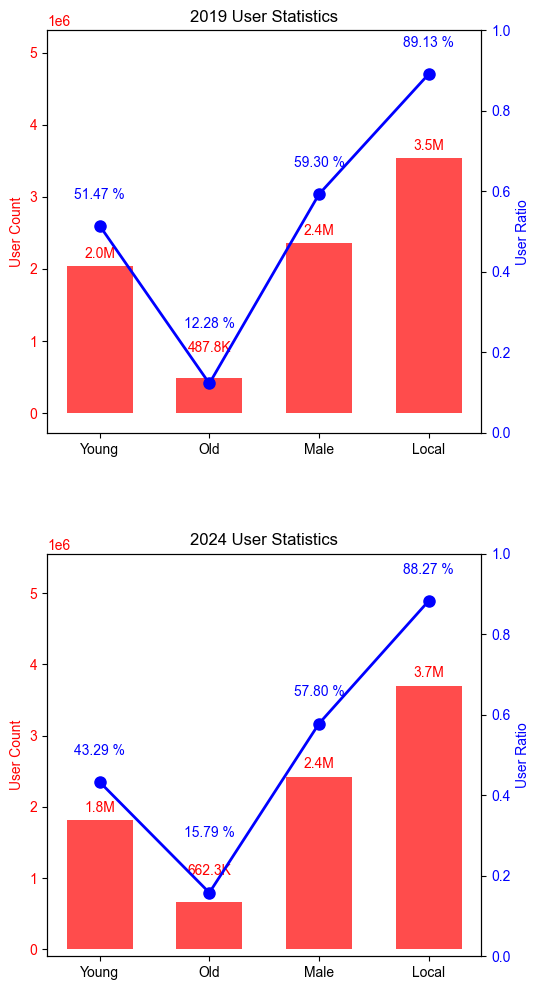

In [11]:
def calculate_weighted_means(attr_data, grid_data):
    merged = pd.merge(attr_data, grid_data, on='home_grid')
    total_pop = merged['pcount'].sum()
    young_mean = (merged['young_ratio'] * merged['pcount']).sum() / total_pop
    old_mean = (merged['old_ratio'] * merged['pcount']).sum() / total_pop
    male_mean = (merged['male_ratio'] * merged['pcount']).sum() / total_pop
    local_mean = (merged['local_ratio'] * merged['pcount']).sum() / total_pop
    return young_mean, old_mean, male_mean, local_mean, total_pop

def calculate_absolute_values(attr_data, grid_data):
    merged = pd.merge(attr_data, grid_data, on='home_grid')
    young_abs = (merged['young_ratio'] * merged['pcount']).sum()
    old_abs = (merged['old_ratio'] * merged['pcount']).sum()
    male_abs = (merged['male_ratio'] * merged['pcount']).sum()
    local_abs = (merged['local_ratio'] * merged['pcount']).sum()
    return young_abs, old_abs, male_abs, local_abs

def create_plot(ax, year, ratios, abs_values):
    x = np.arange(4)
    width = 0.6
    # Calculate y-axis limits for left axis
    min_abs = min(abs_values)
    max_abs = max(abs_values)
    abs_range = max_abs - min_abs

    ax.set_ylim(min_abs - 0.25 * abs_range, max_abs * 1.5)

    # Left y-axis: Absolute values (bar chart)
    bars = ax.bar(x, abs_values, width, alpha=0.7, color='red')
    ax.set_ylabel('User Count', color='red', fontsize=10)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xlabel('')
    ax.set_xticks(x)
    ax.set_xticklabels(['Young', 'Old', 'Male', 'Local'])
    ax.set_title(f'{year} User Statistics', fontsize=12)

    # Add absolute values as text on top of bars
    for i, v in enumerate(abs_values):
        # Format large numbers with K (thousands) or M (millions) notation
        if v >= 1_000_000:
            label_text = f'{v/1_000_000:.1f}M'
        elif v >= 1_000:
            label_text = f'{v/1_000:.1f}K'
        else:
            label_text = f'{v:.0f}'
        
        if i == 1:
            ax.text(i, v + max(abs_values)*0.09, label_text, ha='center', va='bottom', color='red')
        else:
            ax.text(i, v + max(abs_values)*0.02, label_text, ha='center', va='bottom', color='red')

    # Right y-axis: Ratio values (line plot)
    ax2 = ax.twinx()
    line = ax2.plot(x, ratios, 'bo-', linewidth=2, markersize=8, label='Ratio Values')
    ax2.set_ylabel('User Ratio', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 1)

    for i, v in enumerate(ratios):
        if i == 1:
            ax2.text(i, v + 0.13, f'{v*100:.2f} %', ha='center', va='bottom', color='blue')
        else:
            ax2.text(i, v + 0.06, f'{v*100:.2f} %', ha='center', va='bottom', color='blue')

young_1903, old_1903, male_1903, local_1903, pop_1903 = calculate_weighted_means(
    pcount1903_attr[pcount1903_attr['home_grid'].isin(home_grid)], 
    pcount1903_grid_s[pcount1903_grid_s['home_grid'].isin(home_grid)]
)

merged_1903 = pd.merge(
    pcount1903_attr[pcount1903_attr['home_grid'].isin(home_grid)], 
    pcount1903_grid_s[pcount1903_grid_s['home_grid'].isin(home_grid)], 
    on='home_grid'
)
young_abs_1903, old_abs_1903, male_abs_1903, local_abs_1903 = calculate_absolute_values(
    pcount1903_attr[pcount1903_attr['home_grid'].isin(home_grid)], 
    pcount1903_grid_s[pcount1903_grid_s['home_grid'].isin(home_grid)]
)

# Calculate 2024 data
young_2403, old_2403, male_2403, local_2403, pop_2403 = calculate_weighted_means(
    pcount2403_attr[pcount2403_attr['home_grid'].isin(home_grid)], 
    pcount2403_grid_s[pcount2403_grid_s['home_grid'].isin(home_grid)]
)

merged_2403 = pd.merge(
    pcount2403_attr[pcount2403_attr['home_grid'].isin(home_grid)], 
    pcount2403_grid_s[pcount2403_grid_s['home_grid'].isin(home_grid)], 
    on='home_grid'
)
young_abs_2403, old_abs_2403, male_abs_2403, local_abs_2403 = calculate_absolute_values(
    pcount2403_attr[pcount2403_attr['home_grid'].isin(home_grid)], 
    pcount2403_grid_s[pcount2403_grid_s['home_grid'].isin(home_grid)]
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 10))

# Create 2019 plot
create_plot(ax1, '2019', 
            [young_1903, old_1903, male_1903, local_1903],
            [young_abs_1903, old_abs_1903, male_abs_1903, local_abs_1903])

# Create 2024 plot
create_plot(ax2, '2024', 
            [young_2403, old_2403, male_2403, local_2403],
            [young_abs_2403, old_abs_2403, male_abs_2403, local_abs_2403])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

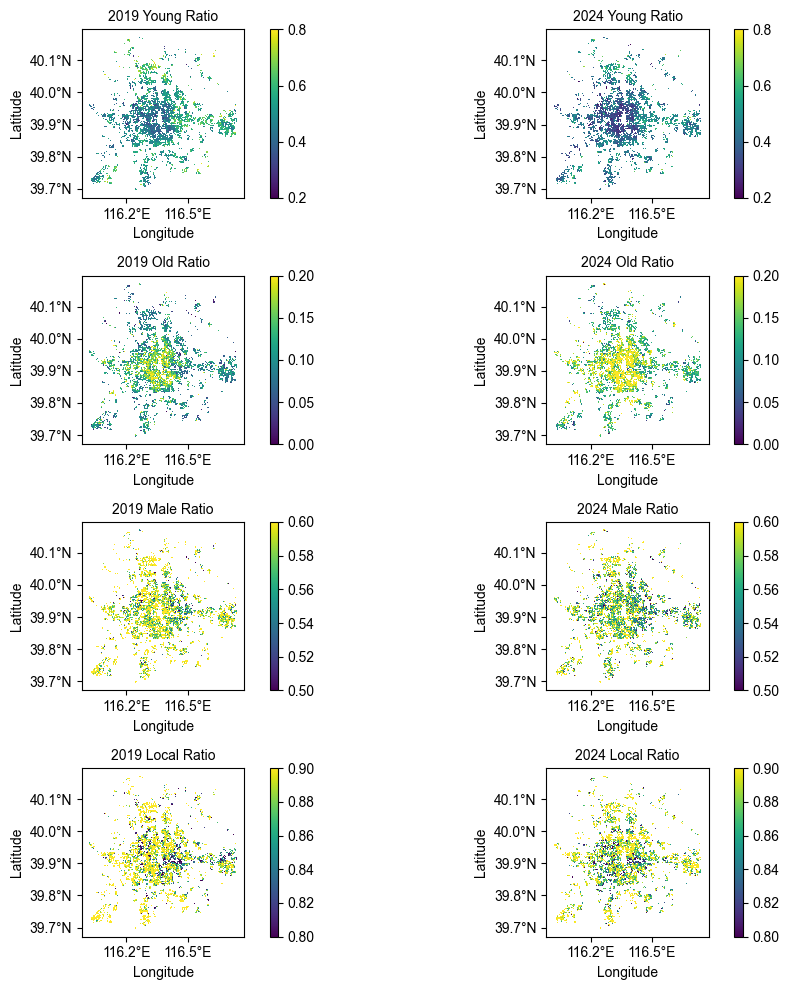

In [12]:
merged_1903 = city_grid.loc[:,['fnid','geometry']].merge(pcount1903_attr.rename(columns={'home_grid':'fnid'}))
merged_2403 = city_grid.loc[:,['fnid','geometry']].merge(pcount2403_attr.rename(columns={'home_grid':'fnid'}))

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

# Define a function to apply consistent formatting to each axis
def format_geo_axis(ax):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}°E"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}°N"))

# 2019 Plots (Left Column)
merged_1903.plot('young_ratio', vmin=0.2, vmax=0.8, legend=True, ax=axes[0, 0])
axes[0, 0].set_title('2019 Young Ratio', fontsize=10)
format_geo_axis(axes[0, 0])

merged_1903.plot('old_ratio', vmax=0.2, legend=True, ax=axes[1, 0])
axes[1, 0].set_title('2019 Old Ratio', fontsize=10)
format_geo_axis(axes[1, 0])

merged_1903.plot('male_ratio', vmin=0.5, vmax=0.6, legend=True, ax=axes[2, 0])
axes[2, 0].set_title('2019 Male Ratio', fontsize=10)
format_geo_axis(axes[2, 0])

merged_1903.plot('local_ratio', vmin=0.8, vmax=0.9, legend=True, ax=axes[3, 0])
axes[3, 0].set_title('2019 Local Ratio', fontsize=10)
format_geo_axis(axes[3, 0])

# 2024 Plots (Right Column)
merged_2403.plot('young_ratio', vmin=0.2, vmax=0.8, legend=True, ax=axes[0, 1])
axes[0, 1].set_title('2024 Young Ratio', fontsize=10)
format_geo_axis(axes[0, 1])

merged_2403.plot('old_ratio', vmax=0.2, legend=True, ax=axes[1, 1])
axes[1, 1].set_title('2024 Old Ratio', fontsize=10)
format_geo_axis(axes[1, 1])

merged_2403.plot('male_ratio', vmin=0.5, vmax=0.6, legend=True, ax=axes[2, 1])
axes[2, 1].set_title('2024 Male Ratio', fontsize=10)
format_geo_axis(axes[2, 1])

merged_2403.plot('local_ratio', vmin=0.8, vmax=0.9, legend=True, ax=axes[3, 1])
axes[3, 1].set_title('2024 Local Ratio', fontsize=10)
format_geo_axis(axes[3, 1])

plt.tight_layout()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

In [13]:
def calculate_age_groups(df):
    # Find young columns (age20 to age39)
    young_cols = [col for col in df.columns if col.startswith('age') and any(str(i) in col for i in range(20,40))]
    
    # Find old columns (age60 to age84)
    old_cols = [col for col in df.columns if col.startswith('age') and any(str(i) in col for i in range(60,85))]
    
    # Add the specific "age85及以" column
    if 'age85及以' in df.columns:
        old_cols.append('age85及以')
    else:
        # Try to find similar columns if exact match not found
        age85_plus_cols = [col for col in df.columns if '85' in col and 'age' in col.lower()]
        if age85_plus_cols:
            old_cols.extend(age85_plus_cols)
    
    # Calculate sums
    df['Young'] = df[young_cols].sum(axis=1)
    df['Old'] = df[old_cols].sum(axis=1)
    
    return df

# Load data
changzhu = gpd.read_file(os.path.join(root, 'data', 'qipu', '02七普常住人口年龄.shp'))
changzhu_wai = gpd.read_file(os.path.join(root, 'data', 'qipu', '03全市常住外来人口年龄.shp'))

# Calculate age groups only for changzhu (as in original code)
changzhu = calculate_age_groups(changzhu)

# Merge datasets (as in original code)
qipu = changzhu.loc[:, ['QH_CODE', '常住人口', 'Young', 'Old']].merge(
    changzhu_wai.loc[:, ['QH_CODE', '常住外来人']],
    on='QH_CODE'
)

# Filter valid data (as in original code)
qipu = qipu.loc[(qipu['常住人口'] > 0) & (qipu['常住外来人'] > 0)]

# Merge with geographic data (as in original code)
changzhu_geo = changzhu.loc[:, ['QH_CODE', '社区名', '街道名', '区县名', 'geometry']].merge(qipu)

# Calculate ratios (as in original code)
changzhu_geo['rate'] = changzhu_geo['常住外来人'] / changzhu_geo['常住人口']
changzhu_geo['young_ratio'] = changzhu_geo['Young'] / changzhu_geo['常住人口']
changzhu_geo['old_ratio'] = changzhu_geo['Old'] / changzhu_geo['常住人口']

# Filter rate < 1 (as in original code)
changzhu_geo_filtered = changzhu_geo.loc[changzhu_geo['rate'] < 1]

# Spatial join with grid (as in original code)
qipu_250m = city_grid.sjoin(
    changzhu_geo_filtered, 
    predicate='intersects', 
    how='left'
).drop(['index_right', 'QH_CODE', '社区名', '街道名', '区县名', 'rate', 'geometry'], axis=1, errors='ignore')

# Aggregate by grid cell (as in original code)
qipu_250m_agg = qipu_250m.groupby(['fnid'], as_index=False).sum()

# Calculate ratios at grid level (as in original code)
qipu_250m_agg['rate'] = 1-qipu_250m_agg['常住外来人'] / qipu_250m_agg['常住人口']
qipu_250m_agg['young_ratio'] = qipu_250m_agg['Young'] / qipu_250m_agg['常住人口']
qipu_250m_agg['old_ratio'] = qipu_250m_agg['Old'] / qipu_250m_agg['常住人口']

# Merge with geometry
qipu_250m_geo = city_grid.merge(qipu_250m_agg, on='fnid', how='left')

# Fill missing values using buffer method (as in original code)
missing_rates = qipu_250m_geo[qipu_250m_geo['rate'].isna()]
if not missing_rates.empty:
    if missing_rates.geometry.type.iloc[0] == 'Polygon':
        missing_points = missing_rates.copy()
        missing_points['geometry'] = missing_points.geometry.centroid
    else:
        missing_points = missing_rates.copy()
    
    missing_points = missing_points.to_crs(epsg=3857)
    missing_points['buffer'] = missing_points.geometry.buffer(500)
    buffered = missing_points.set_geometry('buffer')
    buffered = buffered.to_crs(qipu_250m_geo.crs)
    
    valid_rates = qipu_250m_geo[~qipu_250m_geo['rate'].isna()]
    filled = buffered.sjoin(valid_rates, how='left', predicate='intersects')
    
    mean_rates = filled.groupby(filled.index)['rate_right'].mean().rename('mean_rate')
    qipu_250m_geo.loc[mean_rates.index, 'rate'] = mean_rates
    
    # Also fill young_ratio and old_ratio using the same method
    young_mean = filled.groupby(filled.index)['young_ratio_right'].mean()
    old_mean = filled.groupby(filled.index)['old_ratio_right'].mean()
    qipu_250m_geo.loc[young_mean.index, 'young_ratio'] = young_mean
    qipu_250m_geo.loc[old_mean.index, 'old_ratio'] = old_mean

# Filter to grids with house price data
filtered_geo = qipu_250m_geo.loc[
    qipu_250m_geo['fnid'].isin(house_price_pop['home_grid'].unique())
]

C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\4092841450.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  missing_points['geometry'] = missing_points.geometry.centroid


In [14]:
def calculate_population_weights(merged_2019, filtered_2020):
    # Select and rename columns
    filtered_2020 = filtered_2020.loc[:, ['fnid', 'young_ratio', 'old_ratio', 'rate']].rename(
        columns={'rate': 'local_ratio'}
    )
    
    # Merge 2019 and 2020 data
    merged = merged_2019.drop('geometry', axis=1).merge(filtered_2020, on='fnid', suffixes=('_2019', '_2020'))
    
    # Calculate weights
    merged['young_weight'] = merged['young_ratio_2020'] / merged['young_ratio_2019']
    merged['old_weight'] = merged['old_ratio_2020'] / merged['old_ratio_2019']
    merged['local_weight'] = merged['local_ratio_2020'] / merged['local_ratio_2019']
    
    # Handle division by zero and invalid values
    for col in ['young_weight', 'old_weight', 'local_weight']:
        merged[col] = merged[col].replace([np.inf, -np.inf], np.nan)
        merged[col] = merged[col].fillna(1)  # Set to 1 when denominator is zero
    
    return merged

# Calculate population weights
a = calculate_population_weights(merged_1903, filtered_geo)
a_geo = city_grid.loc[:, ['fnid', 'geometry']].merge(
    a.rename(columns={'home_grid': 'fnid'}),
    on='fnid',
    how='inner'
)

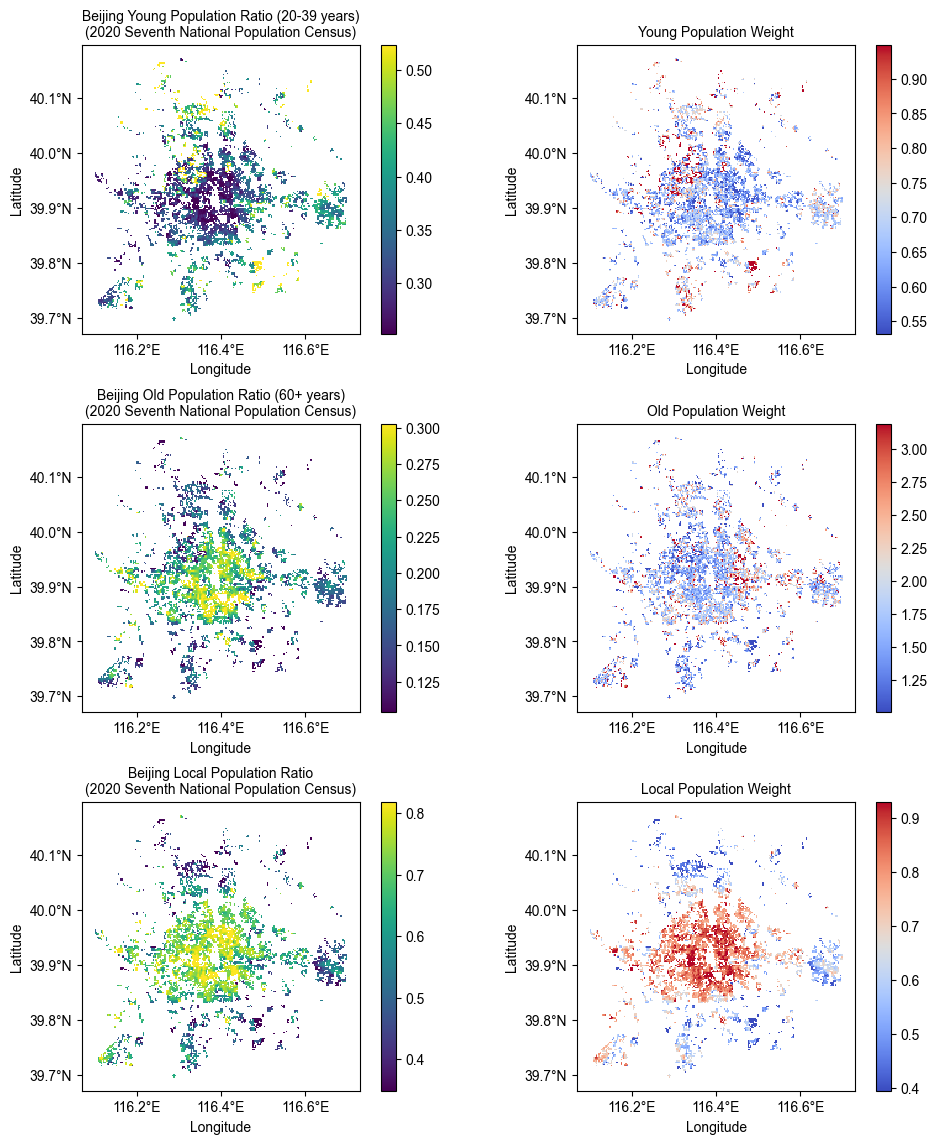

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

def plot_with_quantiles(data, column, ax, title, cmap='viridis'):
    valid_data = data.copy()
    valid_data = valid_data[~valid_data[column].isna()]
    vmin = valid_data[column].quantile(0.05)
    vmax = valid_data[column].quantile(0.95)
    valid_data.plot(
        column=column, 
        ax=ax, 
        legend=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    format_geo_axis(ax)
    ax.set_title(title, fontsize=10)
plot_with_quantiles(filtered_geo, 'young_ratio', axes[0, 0], 
                    'Beijing Young Population Ratio (20-39 years)\n(2020 Seventh National Population Census)')

plot_with_quantiles(a_geo, 'young_weight', axes[0, 1], 
                    'Young Population Weight', 
                    cmap='coolwarm')

plot_with_quantiles(filtered_geo, 'old_ratio', axes[1, 0], 
                    'Beijing Old Population Ratio (60+ years)\n(2020 Seventh National Population Census)')

plot_with_quantiles(a_geo, 'old_weight', axes[1, 1], 
                    'Old Population Weight', 
                    cmap='coolwarm')

plot_with_quantiles(filtered_geo, 'rate', axes[2, 0], 
                    'Beijing Local Population Ratio\n(2020 Seventh National Population Census)')
plot_with_quantiles(a_geo, 'local_weight', axes[2, 1], 
                    'Local Population Weight', 
                    cmap='coolwarm')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

# Origin-Destination (OD) Record Processing

In [16]:
def data_prepross(df):
    df = df.loc[df['age'].isin(['a1', 'a2', 'a3', 'a4', 'a5', 'a6','a7'])]
    visit_count = df.loc[:,['visit_grid','home_grid']].groupby('visit_grid', as_index=False).count()
    df = df.loc[df['visit_grid'].isin(np.array(visit_count.loc[visit_count['home_grid']>=3]['visit_grid']))]
    visit_fre = od1903.loc[:,['home_grid','stay_fre']].groupby('home_grid', as_index=False).sum()
    df = df.loc[df['home_grid'].isin(visit_fre.loc[visit_fre['stay_fre']>60]['home_grid'])]
    df = df.loc[df['age'].isin(['a1','a2','a3','a4','a5','a6','a7'])]
    df.loc[(df['home_grid']==df['visit_grid']) & (df['ptype']!=1), 'ptype'] = 1
    df_ses = df.merge(house_price_pop.loc[:,['home_grid','ses','ses2', 'ses3']])
    return df_ses

In [17]:
def od_distance(od_data):
    od_grid = od_data.loc[od_data['visit_grid'].isin(sixth_fnid), ['home_grid','visit_grid']].drop_duplicates()
    od_grid_h = od_grid.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'home_grid','lon':'hlon','lat':'hlat'}))
    od_grid_hv = od_grid_h.merge(grid_point.loc[:,['fnid','lon','lat']].rename(columns={'fnid':'visit_grid','lon':'vlon','lat':'vlat'}))
    geometry = [LineString(xy_list) for xy_list in zip(zip(od_grid_hv.hlon, od_grid_hv.hlat), zip(od_grid_hv.vlon, od_grid_hv.vlat))]
    od_grid_hv_geo = gpd.GeoDataFrame(od_grid_hv, crs="EPSG:32650", geometry=geometry)
    od_grid_hv_geo['distance'] = round(od_grid_hv_geo.length, 0).astype('int')
    return od_grid_hv_geo.loc[:,['home_grid','visit_grid','distance']]

# od_distance1903 = od_distance(od1903)
# od_distance2403 = od_distance(od2403)

# od_distance1903.to_csv('od_distance1903', index=False)
# od_distance2403.to_csv('od_distance2403', index=False)
# pd.concat([od_distance1903,od_distance2403]).drop_duplicates().to_csv('od19_24_fnid_distance.csv')
# unit: meter
od_line_geo = pd.read_csv(os.path.join(root, 'data', 'od19_24_fnid_distance.csv'))

In [18]:
def calculate_distance(row):
    point = row.geometry
    return point.distance(beijing_center_32650)

grid_point_six_c['distance_c'] = grid_point_six_c.apply(calculate_distance, axis=1).astype(int)

D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
def calculate_flow_stats(data):
    # Calculate total flow
    total_flow = data['stay_fre'].sum()
    
    # Calculate flow ratios
    male_ratio = data.loc[data['gender'] == 1]['stay_fre'].sum() / total_flow
    local_ratio = data.loc[data['is_local'] == 'Y']['stay_fre'].sum() / total_flow
    young_ratio = data.loc[data['age'].isin(['a1','a2','a3'])]['stay_fre'].sum() / total_flow
    old_ratio = data.loc[data['age'].isin(['a6','a7'])]['stay_fre'].sum() / total_flow
    
    # Calculate absolute flow values
    male_abs = data.loc[data['gender'] == 1]['stay_fre'].sum()
    local_abs = data.loc[data['is_local'] == 'Y']['stay_fre'].sum()
    young_abs = data.loc[data['age'].isin(['a1','a2','a3'])]['stay_fre'].sum()
    old_abs = data.loc[data['age'].isin(['a6','a7'])]['stay_fre'].sum()
    
    return young_ratio, old_ratio, male_ratio, local_ratio, young_abs, old_abs, male_abs, local_abs
    
# Calculate flow statistics for 2019
a_1903 = data_prepross(od1903)
young_ratio_1903, old_ratio_1903, male_ratio_1903, local_ratio_1903, \
young_abs_1903, old_abs_1903, male_abs_1903, local_abs_1903 = calculate_flow_stats(a_1903)

# Calculate flow statistics for 2024
a_2403 = data_prepross(od2403)
young_ratio_2403, old_ratio_2403, male_ratio_2403, local_ratio_2403, \
young_abs_2403, old_abs_2403, male_abs_2403, local_abs_2403 = calculate_flow_stats(a_2403)

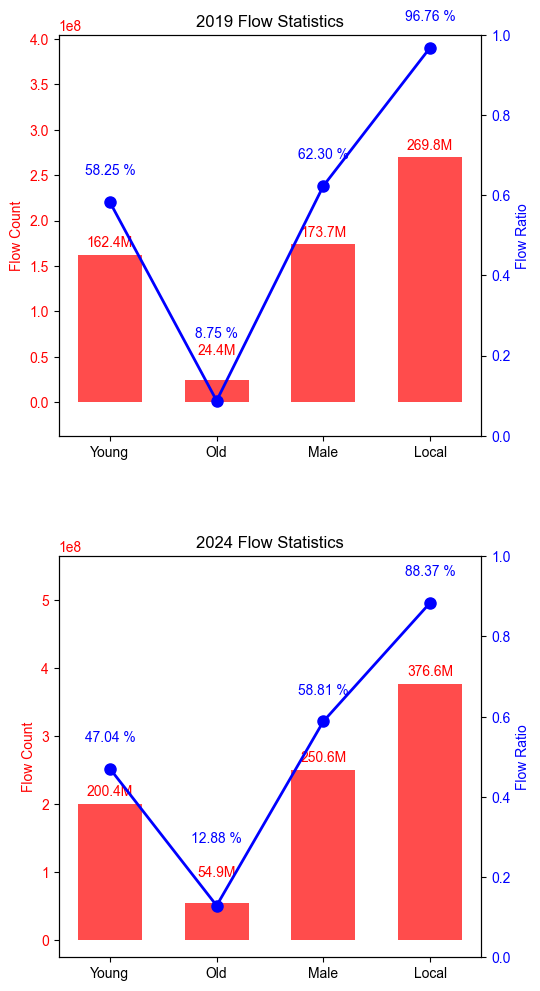

In [20]:
def create_flow_plot(ax, year, ratios, abs_values):
    # X-axis positions
    x = np.arange(4)
    width = 0.6
    min_abs = min(abs_values)
    max_abs = max(abs_values)
    abs_range = max_abs - min_abs
    ax.set_ylim(min_abs - 0.25 * abs_range, max_abs * 1.5)
    bars = ax.bar(x, abs_values, width, alpha=0.7, color='red')
    ax.set_ylabel('Flow Count', color='red', fontsize=10)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_xlabel('')
    ax.set_xticks(x)
    ax.set_xticklabels(['Young', 'Old', 'Male', 'Local'])
    ax.set_title(f'{year} Flow Statistics', fontsize=12)
    for i, v in enumerate(abs_values):
        if v >= 1_000_000:
            label_text = f'{v/1_000_000:.1f}M'
        elif v >= 1_000:
            label_text = f'{v/1_000:.1f}K'
        else:
            label_text = f'{v:.0f}'
        if i == 1:
            ax.text(i, v + max(abs_values)*0.09, label_text, ha='center', va='bottom', color='red')
        else:
            ax.text(i, v + max(abs_values)*0.02, label_text, ha='center', va='bottom', color='red')
    ax2 = ax.twinx()
    line = ax2.plot(x, ratios, 'bo-', linewidth=2, markersize=8, label='Flow Ratio')
    ax2.set_ylabel('Flow Ratio', color='blue', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 1)
    for i, v in enumerate(ratios):
        if i == 1:
            ax2.text(i, v + 0.15, f'{v*100:.2f} %', ha='center', va='bottom', color='blue')
        else:
            ax2.text(i, v + 0.06, f'{v*100:.2f} %', ha='center', va='bottom', color='blue')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 10))

create_flow_plot(ax1, '2019',
                 [young_ratio_1903, old_ratio_1903, male_ratio_1903, local_ratio_1903],
                 [young_abs_1903, old_abs_1903, male_abs_1903, local_abs_1903])

create_flow_plot(ax2, '2024',
                 [young_ratio_2403, old_ratio_2403, male_ratio_2403, local_ratio_2403],
                 [young_abs_2403, old_abs_2403, male_abs_2403, local_abs_2403])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

In [21]:
def visit_ses_fre(data):
    data_new = data_prepross(data)
    data_new = data_new.merge(od_line_geo)
    data_visit = data_new.loc[(data_new['visit_grid'].isin(sixth_fnid))]

    b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()
    b_wide = b.pivot(index='visit_grid', columns='ses2', values='stay_fre')
    b_wide.columns.name = None
    b_wide = b_wide.reset_index()
    b_wide.columns = ['visit_grid','ses1_fre','ses2_fre','ses3_fre','ses4_fre']

    b_wide['total_fre'] = b_wide[['ses1_fre', 'ses2_fre', 'ses3_fre', 'ses4_fre']].sum(axis=1)

    for col in ['ses1_fre', 'ses2_fre', 'ses3_fre', 'ses4_fre']:
        b_wide[col] = b_wide[col] / b_wide['total_fre'] * 100

    b_wide = b_wide.drop(columns=['total_fre'])
    return b_wide

visit_ses_fre1903 = visit_ses_fre(od1903)
visit_ses_fre2403 = visit_ses_fre(od2403)

C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\3944640834.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\3944640834.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()


In [22]:
# visit_ses_fre1903.to_csv(os.path.join(root, 'data', 'visit_ses_fre1903.csv'), index=False)
# visit_ses_fre2403.to_csv(os.path.join(root, 'data', 'visit_ses_fre2403.csv'), index=False)

In [23]:
def visit_ses_fre(data):
    data_new = data_prepross(data)
    data_new = data_new.merge(od_line_geo)
    # data_visit = data_new.loc[(data_new['ptype']!=1) & (data_new['visit_grid'].isin(sixth_fnid)) & (data_new['distance']>250)]
    data_visit = data_new.loc[(data_new['visit_grid'].isin(sixth_fnid))]
    b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()
    b_wide = b.pivot(index='visit_grid', columns='ses2', values='stay_fre')
    b_wide.columns.name = None
    b_wide = b_wide.reset_index()
    b_wide.columns = ['visit_grid','ses1_fre','ses2_fre','ses3_fre','ses4_fre']
    return b_wide

visit_ses_fre1903 = visit_ses_fre(od1903)
visit_ses_fre2403 = visit_ses_fre(od2403)
# visit_ses_fre1903.to_csv(os.path.join(root, 'data', 'visit_ses_fre1903.csv'), index=False)
# visit_ses_fre2403.to_csv(os.path.join(root, 'data', 'visit_ses_fre2403.csv'), index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\3206417733.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()
C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\3206417733.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  b = data_visit.loc[data_visit['ptype']!=1, ['visit_grid','ses2','stay_fre']].groupby(['visit_grid','ses2']).sum().unstack().fillna(0).stack().reset_index()


In [24]:
visit_home_distance_ses = od_line_geo.merge(house_price_pop.loc[:,['home_grid','ses2']]).drop('home_grid',axis=1).groupby(['visit_grid','ses2'], as_index=False).mean()
visit_home_distance_ses['distance'] = round(visit_home_distance_ses['distance'],0).astype('int')
visit_home_distance_ses.to_csv(os.path.join(root, 'data', 'visit_home_distance_ses.csv'), index=False)

# Calculating Location Segregation

In [25]:
def ses_isolation(time_seq):
    time_seq = np.array(time_seq)
    time_seq = time_seq/time_seq.sum()
    n = len(time_seq)
    ses_d = n/(2*n-2)*(np.abs(np.array(time_seq) - 1/n)).sum()
    return ses_d
# function sample
# ses_isolation(np.array([0.25,0.25,0.25,0.25]))

def visit_isolation(data):
    data_new = data_prepross(data)
    data_visit = data_new.loc[(data_new['ptype']!=1) & (data_new['visit_grid'].isin(sixth_fnid))]
    visit_grid_sum = data_visit.loc[:,['visit_grid','sum_time']].groupby(['visit_grid'], as_index=False).sum()
    visit_grid_ses_sum = data_visit.loc[:,['visit_grid','ses2','sum_time']].groupby(['visit_grid','ses2'], as_index=False).sum()
    visit_grid_ses_merge = visit_grid_ses_sum.merge(visit_grid_sum, on='visit_grid', suffixes=('_ses',''))
    visit_grid_ses_merge['grid_ses_prob'] = visit_grid_ses_merge['sum_time_ses']/visit_grid_ses_merge['sum_time']
    iso_array = []
    iso_len = len(np.unique(data_visit['ses2']))
    for visit_grid in tqdm(data_visit['visit_grid'].unique()):
        ses_contact_array = np.array(visit_grid_ses_merge.loc[visit_grid_ses_merge['visit_grid']==visit_grid, ['grid_ses_prob']]).T[0]
        
        ses_contact_array = np.pad(ses_contact_array, (0, iso_len-len(ses_contact_array)), mode='constant', constant_values=0)
        isolation = ses_isolation(ses_contact_array)
        iso_array.append(isolation)
    
    visit_iso_df = pd.DataFrame({'visit_grid':data_visit['visit_grid'].unique(),
                            'isolation':iso_array})
    
    return visit_iso_df

visit_iso1903 = visit_isolation(od1903)
visit_iso2403 = visit_isolation(od2403)

100%|███████████████████████████████████████████████████████████████████████████| 36398/36398 [00:53<00:00, 674.16it/s]


In [26]:
def weighted_avg(group, col, weight_col):
    return (group[col] * group[weight_col]).sum() / group[weight_col].sum()

def cal_visit_ses(od_data):
    data_new = data_prepross(od_data)
    data_att = data_new.merge(od_line_geo, on=['home_grid', 'visit_grid'])
    data_visit = data_att.loc[(data_att['ptype']!=1) & (data_att['distance']>365)]
    data_visit_time = data_visit.loc[:,['visit_grid','ses','sum_time']].groupby(['visit_grid','ses'], as_index=False).sum()
    data_visit_grid_attr = data_visit_time.groupby('visit_grid').apply(weighted_avg, 'ses', 'sum_time').reset_index(name='avg_ses')
    data_visit_grid_attr['avg_ses'] = data_visit_grid_attr['avg_ses'].apply(round) # lambda x: np.ceil(x/10).astype(int)
    return city_grid.loc[:,['fnid','geometry']].merge(data_visit_grid_attr.rename(columns={'visit_grid':'fnid'}))

In [27]:
visit_ses_geo1903 = cal_visit_ses(od1903)
visit_ses_geo2403 = cal_visit_ses(od2403)

C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\1802478612.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_visit_grid_attr = data_visit_time.groupby('visit_grid').apply(weighted_avg, 'ses', 'sum_time').reset_index(name='avg_ses')
C:\Users\DELL\AppData\Local\Temp\ipykernel_66916\1802478612.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_visit_grid_attr = data_visit_time.groupby('visit_grid').apply(w

# Calculating Experienced Individual Segregation

In [28]:
# exprience segregation
def ses_isolation(time_seq):
    time_seq = np.array(time_seq)
    time_seq = time_seq/time_seq.sum()
    n = len(time_seq)
    ses_d = n/(2*n-2)*(np.abs(np.array(time_seq) - 1/n)).sum()
    return ses_d

ses_isolation(np.array([0.25,0.25,0.25,0.25]))

# group_list = ['ses2','home_grid','gender','age','is_local']
from tqdm import tqdm
def experience_iso(data):
    data_new = data_prepross(data)
    data_new = data_new.merge(od_line_geo)
    data_visit = data_new.loc[(data_new['ptype']!=1)&(data_new['distance']>0),['home_grid','visit_grid','sum_time']] # 252
    visit_grid_sum = data_visit.loc[:,['visit_grid','sum_time']].groupby(['visit_grid'], as_index=False).sum()
    visit_grid_ses_sum = data_new.loc[:,['visit_grid','ses2','sum_time']].groupby(['visit_grid','ses2'], as_index=False).sum()
    visit_grid_ses_merge = visit_grid_ses_sum.merge(visit_grid_sum, on='visit_grid', suffixes=('_ses',''))
    visit_grid_ses_merge['grid_ses_prob'] = visit_grid_ses_merge['sum_time_ses']/visit_grid_ses_merge['sum_time']
    
    isolation_array = []
    home_array = []
    # age_array = []
    # gender_array = []
    # local_array = []

    for home_i in tqdm(data_new['home_grid'].unique()):
        home_i_visit = data_visit.loc[(data_visit['home_grid']==home_i), ['visit_grid','sum_time']].groupby(['visit_grid'], as_index=False).sum()
        home_i_visit_prob = home_i_visit.merge(visit_grid_ses_merge.loc[:,['visit_grid','ses2','grid_ses_prob']], on='visit_grid', how='inner')
        home_i_visit_prob['contact_prob_time'] = home_i_visit_prob['sum_time'] * home_i_visit_prob['grid_ses_prob']
        home_i_ses_contact = home_i_visit_prob.loc[:,['ses2','contact_prob_time']].groupby('ses2', as_index=False).sum()
        ses_contact_array = np.array(home_i_ses_contact['contact_prob_time']/home_i_visit['sum_time'].sum())
        isolation = ses_isolation(ses_contact_array)
        isolation_array.append(isolation)
        home_array.append(home_i)
        # age_array.append(age_i)

    
    home_iso_df = pd.DataFrame({'home_grid':home_array,
                                # 'age':age_array,
                                # 'gender':gender_array,
                                # 'is_local':local_array,
                                'isolation':isolation_array})

    home_iso_ses_df = home_iso_df.merge(data_new.loc[:,['home_grid','ses','ses2']].drop_duplicates(), on='home_grid')
    
    return home_iso_ses_df

In [29]:
home_experience_iso1903 = experience_iso(od1903)
home_experience_iso2403 = experience_iso(od2403)

100%|██████████████████████████████████████████████████████████████████████████████| 6762/6762 [25:11<00:00,  4.47it/s]


# Calculating Intergroup Contact Probability

In [ ]:
sample_size = 500000
np.random.seed(42)

def calculate_probabilities(df):
    total = df.groupby('home_grid')['sum_time'].sum().reset_index()
    merged = df.merge(total, on='home_grid', suffixes=('', '_sum'))
    merged['sum_time_prob'] = merged['sum_time'] / merged['sum_time_sum']
    return merged


def generate_random_pairs(unique_values, sample_size=sample_size):
    pairs = [(a, b) for i, a in enumerate(unique_values) for b in unique_values[i + 1:]]
    if len(pairs) < sample_size:
        sample_size = len(pairs)
    indices = np.random.choice(len(pairs), size=sample_size, replace=False)
    return np.array([pairs[i] for i in indices])


def calc_grid_contact_prob(pair, prob_df):
    a, b = pair
    adf = prob_df[prob_df['home_grid'] == a]
    bdf = prob_df[prob_df['home_grid'] == b]
    contact_grid = np.intersect1d(adf['visit_grid'], bdf['visit_grid'])
    if len(contact_grid) == 0:
        return {'home_a': a, 'home_b': b, 'concat_prob': 0}
    adf_contact = adf[adf['visit_grid'].isin(contact_grid)][['visit_grid', 'sum_time_prob']]
    bdf_contact = bdf[bdf['visit_grid'].isin(contact_grid)][['visit_grid', 'sum_time_prob']]
    merged = adf_contact.merge(bdf_contact, on='visit_grid', suffixes=('_a', '_b'))
    return {'home_a': a, 'home_b': b, 'concat_prob': (merged['sum_time_prob_a'] * merged['sum_time_prob_b']).sum() * 100000}

def home_contact_data(data, sample_size=sample_size):
    data_new = data_prepross(data) 
    data_visit = data_new.loc[
        (data_new['ptype'] != 1) & 
        (data_new['visit_grid'].isin(sixth_fnid))
    ]
    visit_grid_sum = data_visit.loc[:, ['home_grid', 'visit_grid', 'sum_time']].groupby(
        ['home_grid', 'visit_grid'], as_index=False
    ).sum()
    
    visit_od_df_sum_m = calculate_probabilities(visit_grid_sum)
    
    home_fnid = visit_od_df_sum_m['home_grid'].unique()
    args_grids_random = generate_random_pairs(home_fnid, sample_size=sample_size)
    
    grid_contact_results = Parallel(n_jobs=60)(
        delayed(calc_grid_contact_prob)(pair, visit_od_df_sum_m) 
        for pair in tqdm(args_grids_random)
    )
    
    return pd.DataFrame(grid_contact_results)

# # 记录时间
# import time
# start_time = time.time()
# print('2019')
# home_contact_data1903 = home_contact_data(od1903)
# print('2024')
# home_contact_data2403 = home_contact_data(od2403)
# end_time = time.time()
# print(end_time - start_time, "s")

2019


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [7:58:05<00:00, 17.43it/s]


2024


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [8:56:42<00:00, 15.53it/s]


60984.533670187 s


# Urban Infrastructure Distribution

In [30]:
poi = gpd.read_file(os.path.join(root, 'data', 'shp', 'poi_Beijing_insix.shp')) # 2024
poi2019 = gpd.read_file(os.path.join(root, 'data', 'shp', 'poi_Beijing_insix_2018.shp'))

In [31]:
poi['中类'].unique()

array(['公交站', '公厕', '中国菜', '物流', '其他', '市场', '家电数码', '小吃快餐', '超市', '台球',
       '家居建材', '小学', '便利店', '诊所', '洗衣', '汽车销售', '汽车配件', '汽车养护', '医药销售',
       '汽车维修', '公司', '美容理发', '中介', 'ATM', '农林牧渔', '公园', '别墅区', '写字楼',
       '高等教育', '职业技术教育', '停车场', '成人教育', 'KTV', '图书馆', '综合医院', '度假养老',
       '幼儿园', '中学', '培训单位', '充电站', '信息咨询中心', '旅馆', '文化宫', '电讯营业厅', '工厂',
       '马术&赛马', '加油站', '住宅区', '景点', '产业园', '收费站', '茶座', '社区中心', '洗浴推拿',
       '汽车租赁', '四星级酒店', '彩票销售', '地铁', '会展展览', '网吧', '外国菜', '游乐场', '健身中心',
       '足球', '广播电视', '银行', '科研单位', '宗教', '农家乐', '宿舍', '广场', '户外健身场所',
       '文体用品', '洗车', '火车', '蛋糕甜品店', '植物园', '三星级酒店', '冰雪运动', '水族馆', '花鸟鱼虫',
       '动物医疗', '专科医院', '长途汽车', '纪念馆', '邮局', '摄影打印', '羽毛球', '博物馆', '咖啡',
       '保险', '高尔夫球', '百货商场', '疾病预防', '游泳', '网球', '动物园', '五星级酒店', '篮球',
       '露营地', '艺术团体', '剧场', '服务区', '美术展览', '水上运动', '综合体育馆', '棋牌室', '港口码头',
       '档案馆', '经济型连锁酒店', '购物中心', '酒吧', '急救中心', '二手车', '飞机', '跆拳道',
       '商住两用楼宇', '公共事业', '免税店', '驾校', '投资理财', '加气站', '青旅', '新闻出版',

In [32]:
bus_station = ['公交站']
subway_station = ['地铁']
train_station = ['火车']
airport = ['飞机']
shopping_mall = ['百货商场','购物中心','商业街','超市']
hospital = ['综合医院','专科医院']
school = ['高等教育','小学','中学','幼儿园']
park = ['公园']
gym = ['羽毛球','冰雪运动','网球','综合体育馆','运动场馆','足球','篮球','橄榄球','乒乓球']
museum = ['科技馆','博物馆','天文馆']
library = ['图书馆']
outdoor = ['景点','露营地','户外健身场所'] 

In [33]:
poi['名称'] = poi['名称'].fillna('')
library_poi = poi.loc[(poi['中类'].isin(library)) & (~poi['名称'].str.contains('大学')) & (~poi['名称'].str.contains('学院')) & (~poi['名称'].str.contains('中学')) & (~poi['名称'].str.contains('学校'))]
ariport_poi = poi.loc[poi['中类'].isin(airport)]
bus_station_poi = poi.loc[poi['中类'].isin(bus_station)]
subway_station_poi = poi[poi['中类'].isin(subway_station)]
pattern = r'[A-Z]\d?((南|北|东|西)(南|北|东|西)?)?口'
subway_station_poi['名称'] = subway_station_poi['名称'].str.replace(pattern, '', regex=True).str.strip()
subway_station_poi = subway_station_poi.drop_duplicates(subset=['名称'], keep='first')
train_station_poi = poi[poi['中类'].isin(train_station) & (~poi['名称'].str.contains('机场') & ~poi['名称'].str.contains('售票处站'))]
train_station_poi['名称'] = train_station_poi['名称'].str.split('站').str[0] + '站'
train_station_poi = train_station_poi.drop_duplicates('名称', keep='first')
shopping_mall_poi = poi.loc[poi['中类'].isin(shopping_mall)].drop_duplicates(subset=['名称'], keep='first') 
hospital_poi = poi.loc[(poi['中类'].isin(hospital)) & (~poi['名称'].str.contains('诊所')) & (~poi['名称'].str.contains('服务站')) & (~poi['名称'].str.contains('卫生室')) & (~poi['名称'].str.contains('健康')) & (~poi['名称'].str.contains('卫生中心')) & (~poi['名称'].str.contains('老年')) & (poi['中类']!='专科医院')].drop_duplicates(subset=['名称'], keep='first')
park_poi = poi.loc[poi['中类'].isin(park)].sort_values('名称')
gym_poi = poi.loc[poi['中类'].isin(gym)].sort_values('名称')
museum_poi = poi.loc[poi['中类'].isin(museum)].sort_values('名称')
school_poi = poi.loc[poi['中类'].isin(school)].sort_values('名称')
outdoor_poi = poi.loc[poi['中类'].isin(outdoor)].sort_values('名称')

D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
school_poi2019 = poi2019.loc[(poi2019['中类']=='学校') & (poi2019['小类'].isin(['幼儿园', '小学', '学校', '中学', '高等院校']))]
bus_station_poi2019 = poi2019.loc[poi2019['中类']=='公交车站']
subway_station_poi2019 = poi2019.loc[poi2019['中类']=='地铁站']
train_station_poi2019 = poi2019.loc[poi2019['中类']=='火车站']
shopping_mall_poi2019 = poi2019.loc[poi2019['中类'].isin(['超级市场','综合市场'])]
shopping_mall_poi2019 = shopping_mall_poi2019.loc[shopping_mall_poi2019['小类'].isin(['综合市场|公司企业', '综合市场|政府机构及社会团体',
'家乐福|生活服务', '超市', '超市|购物服务', '北京华联', '华润', '北京华联|购物服务',
'家乐福', '家乐福|购物服务', '上海华联', '麦德龙', '万宁超市', '卜蜂莲花',
'沃尔玛', '乐天玛特', '综合市场|购物服务', '超市|餐饮服务', '上海华联|购物服务', '超市|生活服务',
'惠康超市'])]
hospital_poi2019 = poi2019.loc[(poi2019['中类'].isin(hospital)) & (~poi2019['名称'].str.contains('诊所')) & (~poi2019['名称'].str.contains('服务站')) & (~poi2019['名称'].str.contains('卫生室')) & (~poi2019['名称'].str.contains('健康')) & (~poi2019['名称'].str.contains('卫生中心')) & (~poi2019['名称'].str.contains('老年')) & (poi2019['中类']!='专科医院')].drop_duplicates(subset=['名称'], keep='first')
# hospital_poi = poi2019.loc[poi2019['中类'].isin(['综合医院']) & (~poi2019['名称'].str.contains('诊所')) & (~poi2019['名称'].str.contains('服务站'))]
park_poi2019 = poi2019.loc[(poi2019['中类']=='公园广场') & (poi2019['小类'].str.contains('公园'))]
gym_poi2019 = poi2019.loc[(poi2019['中类'].isin(gym)) & (~poi2019['名称'].str.contains('会所')) & (~poi2019['名称'].str.contains('俱乐部')) & (~poi2019['小类'].str.contains('餐饮')) & (~poi2019['小类'].str.contains('健身'))]
gym_poi2019 = gym_poi2019.loc[gym_poi2019['小类'].isin(['篮球场馆','羽毛球场','足球场','网球场','滑雪场','橄榄球场','乒乓球馆']) & (~gym_poi2019['名称'].str.contains('大学')) & (~gym_poi2019['名称'].str.contains('学院')) & (~gym_poi2019['名称'].str.contains('校区')) & (~gym_poi2019['名称'].str.contains('学校')) & (~gym_poi2019['名称'].str.contains('酒店'))] 
museum_poi2019 = poi2019.loc[poi2019['中类'].isin(museum)]
library_poi2019 = poi2019.loc[(poi2019['中类'].isin(library)) & (~poi2019['名称'].str.contains('大学')) & (~poi2019['名称'].str.contains('学院')) & (~poi2019['名称'].str.contains('校区')) & (~poi2019['名称'].str.contains('学校')) & (~poi2019['名称'].str.contains('酒店'))]
# outdoor_poi2019 = poi2019.loc[(poi2019['小类'].isin(['旅游景点']))]
outdoor_poi2019 = poi2019.loc[((poi2019['小类'].isin(['露营地'])))]
outdoor_poi2019 = pd.concat([poi.loc[poi['中类'].isin(['景点'])].sort_values('名称').loc[:,['名称','geometry']], poi2019.loc[poi2019['小类'].isin(['露营地'])].loc[:,['名称','geometry']], poi2019.loc[poi2019['小类'].str.contains('户外')].loc[:,['名称','geometry']]], axis=0)

In [35]:
def cluster_poi(poi_data, distance):
    poi_data = poi_data.to_crs(32650)
    poi_data['x'] = poi_data['geometry'].apply(lambda x: round(x.x/distance))
    poi_data['y'] = poi_data['geometry'].apply(lambda x: round(x.y/distance))
    # poi_data['cluster'] = DBSCAN(eps=distance, min_samples=1).fit(poi_data[['x','y']]).labels_
    poi_data = poi_data.drop_duplicates(subset=['x','y'], keep='first')
    return poi_data

def find_nearest_points(gdf1, gdf2, kind):
    tree_points = np.array([(p.x, p.y) for p in gdf2.geometry])
    tree = cKDTree(tree_points)
    query_points = np.array([(p.x, p.y) for p in gdf1.geometry])
    distances, indices = tree.query(query_points)
    nearest_ids = gdf2.iloc[indices]['名称'].values
    # gdf1[kind+'_nearest_id'] = nearest_ids
    gdf1[kind+'_dis'] = distances.round(0).astype(int)
    return gdf1

data1 = {
    'id1': [1, 2, 3],
    'geometry': [Point(0, 0), Point(1, 1), Point(2, 2)]
}
gdf1 = gpd.GeoDataFrame(data1, crs='EPSG:4326')

data2 = {
    '名称': ['a','b','c'],
    'geometry': [Point(0.1, 0.1), Point(33.1, 1.1), Point(4.1, 2.1)]
}
gdf2 = gpd.GeoDataFrame(data2, crs='EPSG:4326')
result = find_nearest_points(gdf1, gdf2,'a')

print(result)

   id1     geometry  a_dis
0    1  POINT (0 0)      0
1    2  POINT (1 1)      1
2    3  POINT (2 2)      2


In [36]:
grid_point_six = grid_point.loc[grid_point['fnid'].isin(sixth_fnid)]
poi_kind_list = ['shopping_mall','library','museum','hospital','gym','school','park','outdoor','bus_station','subway_station','train_station']
for kind in poi_kind_list:
    print(kind)
    poi_filter = cluster_poi(eval(kind+'_poi'), 100)
    poi_dis = find_nearest_points(grid_point_six, poi_filter, kind).loc[:,['fnid',kind+'_dis']]
grid_point_six
distance_grid = grid_point_six.drop('geometry', axis=1).merge(city_grid)
distance_grid_geo = gpd.GeoDataFrame(distance_grid, geometry=distance_grid['geometry'], crs="EPSG:4326")

shopping_mall


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


library


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


museum


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


hospital


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


gym


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


school


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


park


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


outdoor


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


bus_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


subway_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


train_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
grid_point_six_2019 = grid_point.loc[grid_point['fnid'].isin(sixth_fnid)]
poi_kind_list = ['shopping_mall','library','museum','hospital','gym','school','park','outdoor','bus_station','subway_station','train_station']
for kind in poi_kind_list:
    print(kind)
    poi_filter = cluster_poi(eval(kind+'_poi2019'), 100) 
    poi_dis = find_nearest_points(grid_point_six_2019, poi_filter, kind).loc[:,['fnid',kind+'_dis']]
grid_point_six_2019
distance_grid = grid_point_six_2019.drop('geometry', axis=1).merge(city_grid)
distance_grid_geo_2019 = gpd.GeoDataFrame(distance_grid, geometry=distance_grid['geometry'], crs="EPSG:4326")

shopping_mall


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


library


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


museum


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


hospital


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


gym


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


school


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


park


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


outdoor


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


bus_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


subway_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


train_station


D:\ProgramData\Anaconda3\envs\geo310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
def find_disntance_poi(gdf1, gdf2, year, distance):
    poi_gdf = globals().get(gdf2 + '_poi'+year)
    poi_gdf = cluster_poi(poi_gdf, 100)
    poi_gdf = poi_gdf.to_crs(32650)
    gdf1 = gdf1.to_crs(32650)
    poi_gdf['buffered_geometry'] = poi_gdf.geometry.buffer(distance)
    df = gpd.sjoin(gdf1, poi_gdf.set_geometry('buffered_geometry'), how='left', predicate='within')
    df_count = df.groupby('fnid')['index_right'].count().reset_index(name=f'{gdf2}_count')
    gdf1 = gdf1.merge(df_count, on='fnid', how='left')
    gdf1[f'{gdf2}_count'] = gdf1[f'{gdf2}_count'].fillna(0)
    return gdf1

In [39]:
home_point = grid_point.loc[grid_point['fnid'].isin(house_price_id), ['fnid', 'geometry']]
for kind in poi_kind_list:
    print(kind)
    home_point = find_disntance_poi(home_point, kind, '2019', 2000)
home_poi_num2019 = home_point[['fnid'] + [f'{kind}_count' for kind in poi_kind_list]+['geometry']]

shopping_mall
library
museum
hospital
gym
school
park
outdoor
bus_station
subway_station
train_station


In [40]:
poi_kind_list = ['shopping_mall', 'library', 'museum', 'hospital', 'gym', 'school', 'park', 'outdoor', 'bus_station', 'subway_station', 'train_station']

house_price_pop = pd.read_csv(os.path.join(root, 'data', 'house_price_pop.csv'))
house_price_id = house_price_pop['home_grid'].unique()
home_point = grid_point.loc[grid_point['fnid'].isin(house_price_id), ['fnid', 'geometry']]
for kind in poi_kind_list:
    print(kind)
    home_point = find_disntance_poi(home_point, kind, '', 2000)

home_poi_num2024 = home_point[['fnid'] + [f'{kind}_count' for kind in poi_kind_list]+['geometry']]

shopping_mall
library
museum
hospital
gym
school
park
outdoor
bus_station
subway_station
train_station


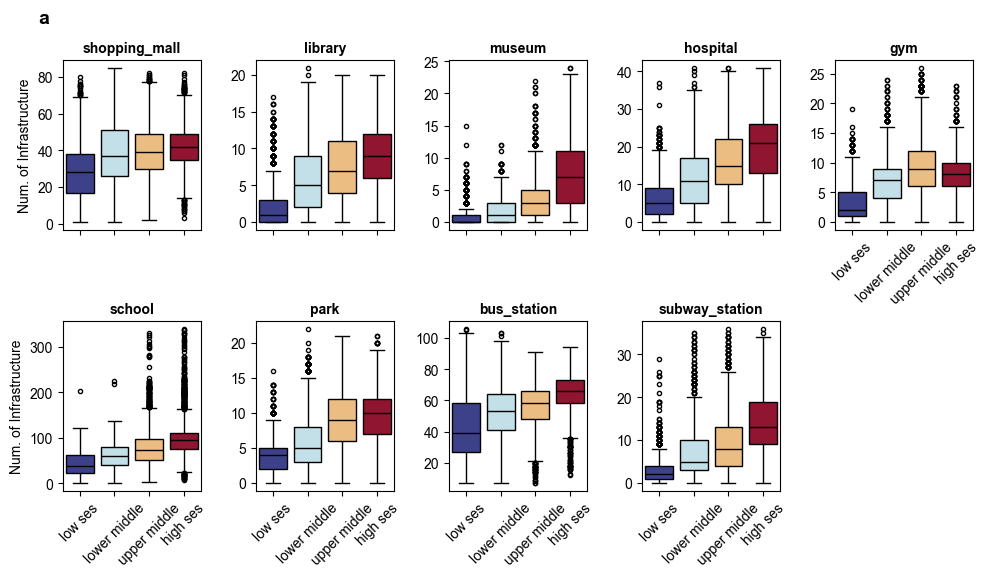

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_boxplot_figure(data, year_label, fig_height_multiplier=3):
    poi_kind_list = ['shopping_mall', 'library', 'museum', 'hospital', 'gym', 'school', 'park', 'bus_station', 'subway_station',]
    n_plots = len(poi_kind_list)
    n_cols = 5
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, fig_height_multiplier * n_rows))
    axes = axes.flatten()
    
    for i, poi_kind in enumerate(poi_kind_list):
        column_name = f'{poi_kind}_count'
        
        sns.boxplot(x='ses2', y=column_name, data=data, ax=axes[i], hue='ses2', palette='RdYlBu_r', 
                    linecolor='black', flierprops=dict(marker='o', markersize=3), legend=False)
        axes[i].set_title(poi_kind, fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        if i % n_cols == 0:
            axes[i].set_ylabel('Num. of Infrastructure')
        else:
            axes[i].set_ylabel('')
        if i < n_plots - n_cols:
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xticks(range(4))
            axes[i].set_xticklabels(['low ses', 'lower middle', 'upper middle', 'high ses'], 
                                   rotation=45, ha='center')
    
    axes[-1].axis('off')
    axes[0].text(-0.1, 1.3, year_label, transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    
    return fig

a_2019 = home_poi_num2019.merge(house_price_pop.loc[:, ['home_grid', 'ses2']], left_on='fnid', right_on='home_grid')
fig1 = create_boxplot_figure(a_2019, 'a')

plt.tight_layout()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()

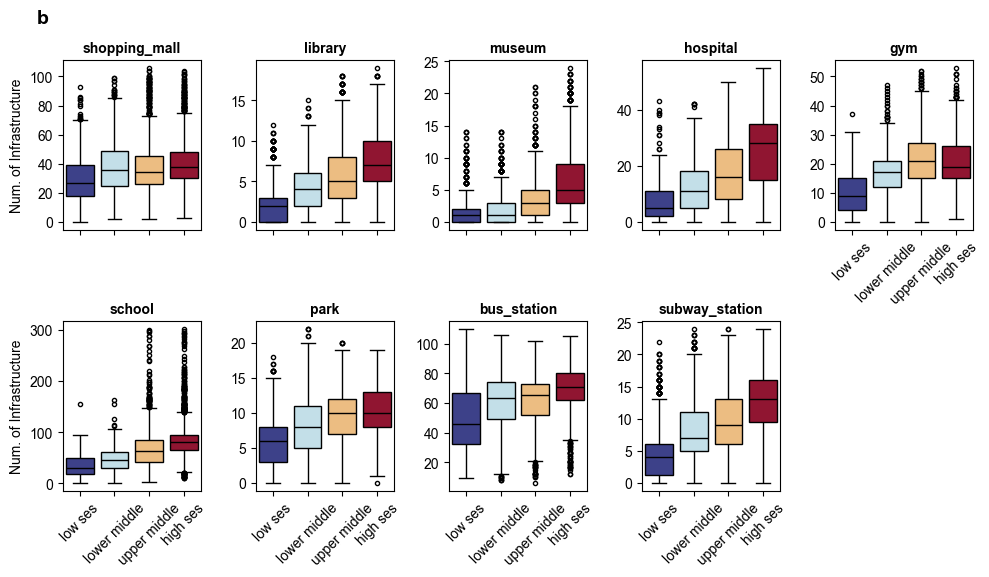

In [42]:
a_2024 = home_poi_num2024.merge(house_price_pop.loc[:, ['home_grid', 'ses2']], left_on='fnid', right_on='home_grid')
fig = create_boxplot_figure(a_2024, 'b')

plt.tight_layout()
# plt.savefig('.png', dpi=500, bbox_inches='tight')
plt.show()